In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

In [2]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

# Dufour et al. 2014 chemotaxis model


In [ ]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,

        :isSource => Bool,
        :S => Float64,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64 #CheYP levels, probability of tumbling

    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        # :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64,
        :DSource => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :A0 => Float64,
        :Yp0 => Float64,   #CheYP adapted
        :α => Float64,      #Gain in thesignaling pathway - from receptor to CheYP
        :λ0 => Float64,    #Tumbling rate - CW bias
        :g => Float64      #Motor gain
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        L = max(mm, 1e-12)  #Concentration, avoid log(0)
        F = ε0 + ε1 * methyl + Nrec * log((1 + L / Ki) / (1 + L / Ka)) #Equació del paper per definir activitat del receptor
        

        A = 1 / (1 + exp(F)) #Receptor activity
        dt(methyl) = (A0 - A) / τm   #Adaptation
        Yp = Yp0 + α * (A - A0)  #CheYP activity depenent on adaptation
        
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta)
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω

    end,

    agentRule = quote

        if isSource
            σ = sqrt(2 * DSource / dt)

            vx = σ * randn()
            vy = σ * randn()
            ω = 0.0

            mm += S
        end

        if tTumble < t && active        #Is running, will change to tumble for 1 second
            vx = 0.0
            vy = 0.0
            active = false
            ω += ωTumble
            tTumble += 1.0              #Paper treballa amb dos rates (tumble and run), afegir aqui??
        elseif tTumble < t && !active       #Time over?
            ω = 0.0                         #Stop tumbling
            active = true                   #Run active
            # λ = λ0 * (Yp /Yp0)  
            ΔY = Yp - Yp0
            λ = λ0 * exp(g * ΔY)            #Tumbling probability
            λ = clamp(λ, 0.05, 20.0)      
            tTumble += CBMDistributions.exponential(1/λ)   #Large lambda = shorter time = more switching; small lambda = longer time = run 
            #Large lambda = short run time = when unfavourable environment = less mm = less Rc activity = more Yp = more tumbling
            #Small lambda = long run time = when favourable environment = more mm = more Rc activity = less Yp = longer run 
            #More Yp = large lambda
            #Less Yp = smaller lambda
        end
 
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	ωTumble (Float64 model)
	Ka (Float64 model)
	γt (Float64 model)
	Nrec (Float64 model)
	τm (Float64 model)
	DSource (Float64 model)
	γn (Float64 model)
	μcw (Float64 model)
	g (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	ε0 (Float64 model)
	λ0 (Float64 model)
	μcc (Float64 model)
	A0 (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	βω (Float64 model)
	Yp0 (Float64 model)
	Ki (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2

In [ ]:
com = Community(
    rods2DChemotaxis,
    N=2,
    dt=0.1,
    simBox=[-20 20;-20 20.],  #change box
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1

com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 0.0
# com.τTumble = 2
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.A0 = 0.5
com.τm = 10.0
com.α   = 6.0
com.Yp0 = 3.0   
com.λ0 = 1.0
com.g = 3.0

com.ωTumble = 1
com.DMedium = 0.00
com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)
com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true

src = 1

# com.active[src] = false 
com.isSource .= false
# com.isSource[src] = true

com.S = 0.0
# com.S[src] = 2.0

Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

for i in 1:Nx, j in 1:Ny
    com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
end


In [6]:
steps = 1000
loadToPlatform!(com, preallocateAgents=2)

for step in 1:steps
    step!(com)
    
end


In [13]:
evolve!(com, steps = 1000, saveEach = 100)

OutOfMemoryError: OutOfMemoryError()

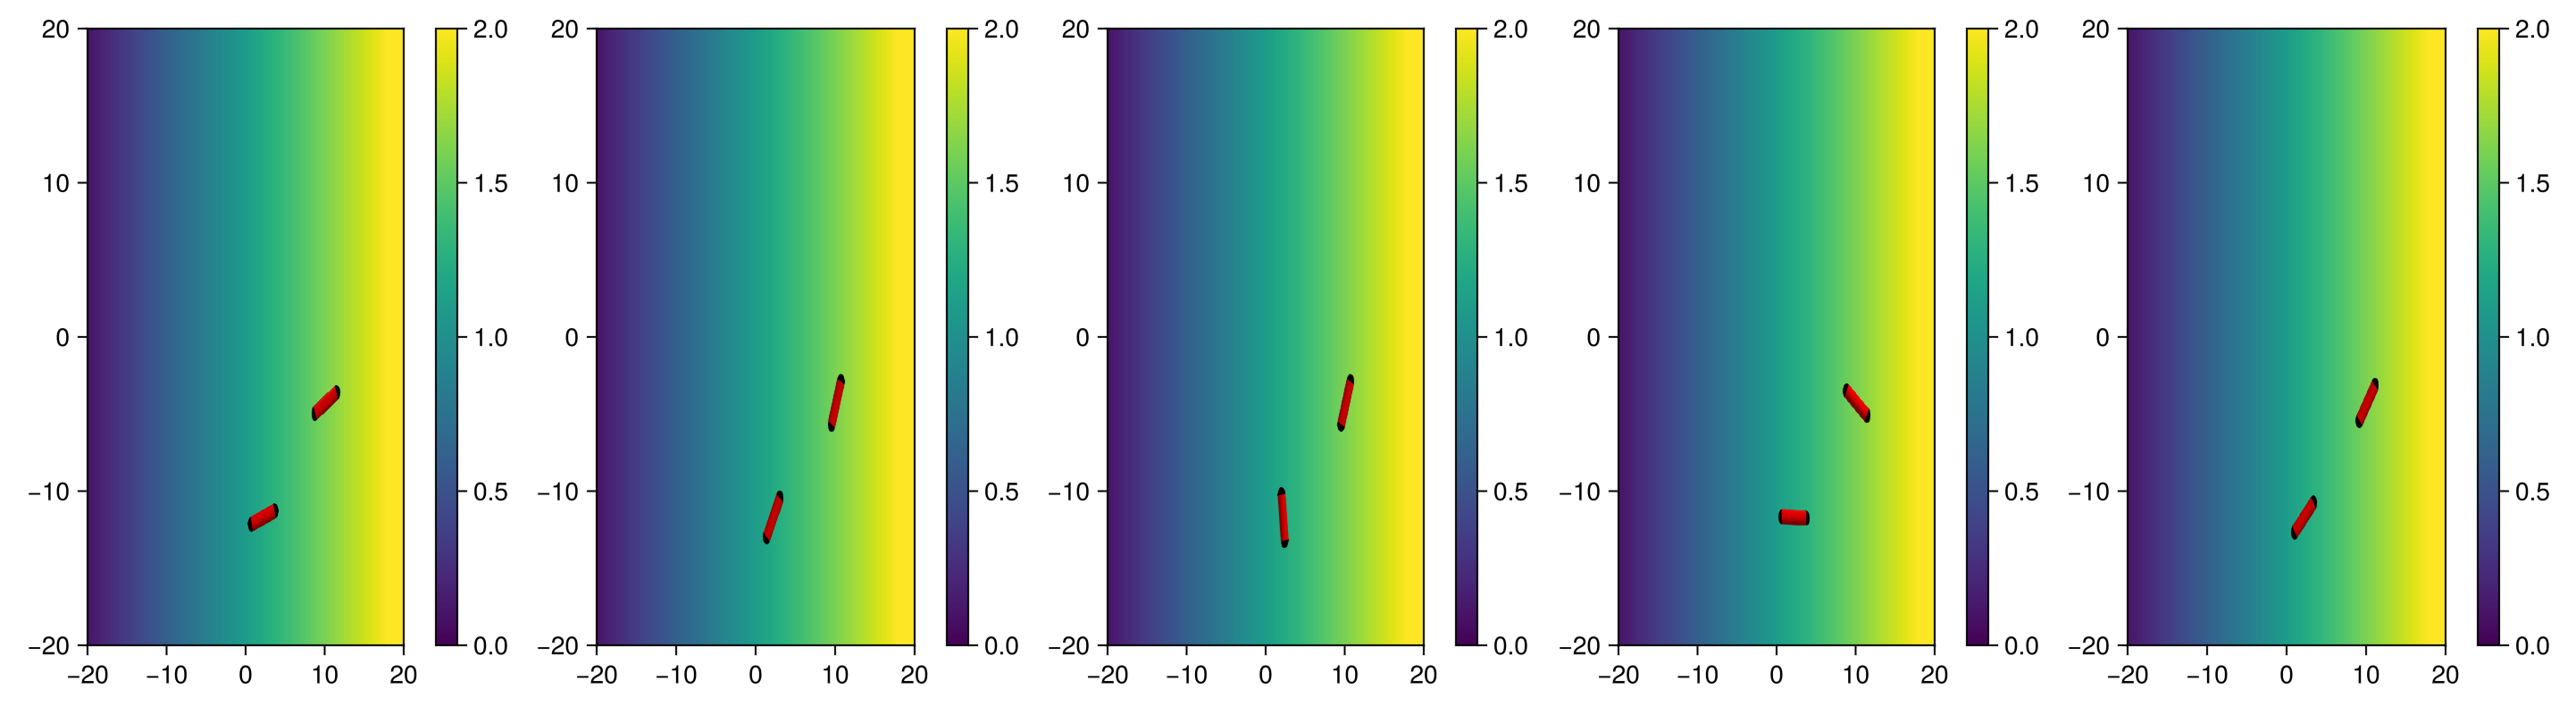

GLMakie.Screen(...)

In [11]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

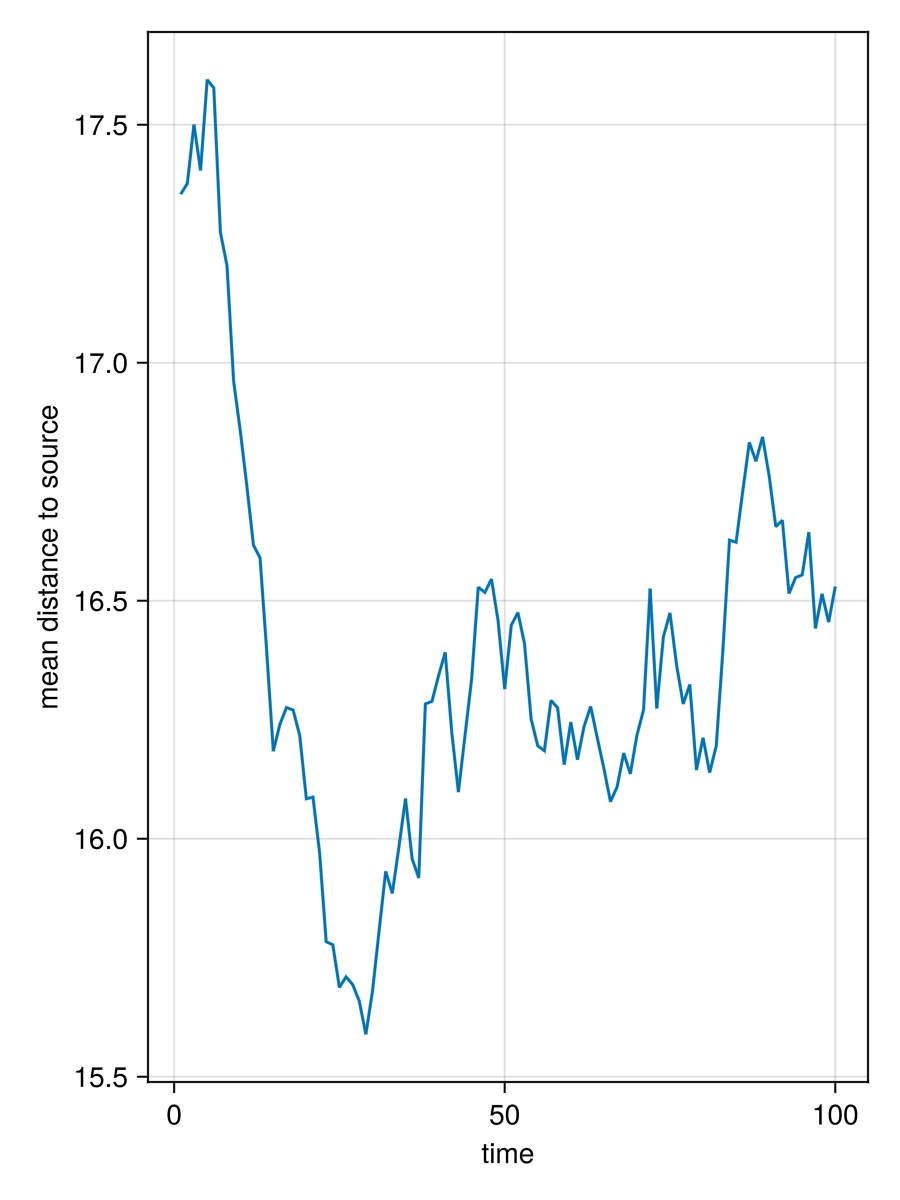

GLMakie.Screen(...)

In [ ]:
d = getParameter(com,[:x])

fig = Figure(size=(400,400))

ax = Axis(fig[1,1],xlabel="time",ylabel="mean(x)",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )
lines!(ax,[i.t for i in com.pastTimes],[mean(i) for i in d[:x]])

display(fig)

In [21]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        # :tTumble => Float64,
        :active => Bool,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64 #CheYP levels, probability of tumbling
    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64,
        :DSource => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :Yp0 => Float64,   #CheYP adapted
        :α => Float64,      #Gain in thesignaling pathway - from receptor to CheYP 
        :ωFrec => Float64       #Basal switching frequency
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        L = max(mm, 1e-12)  #Concentration, avoid log(0)
        F = ε0 + ε1 * methyl + Nrec * log((1 + L / Ki) / (1 + L / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(α / (Yp0 - 1)  )         #Energia lliure en estat adaptat

        dt(methyl) = -(F - F0) / (ε1 * τm)          #Methylation
        Yp = α / (1 + exp(F))                       #CheYp segons activitat receptor

        
        # λrt = ωFrec*exp(-G(Yp(F)))
        
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta)     #fChem es deixa?
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω

    end,

    agentRule = quote

        # if tTumble < t && active        #Is running, will change to tumble for 1 second
        #     vx = 0.0
        #     vy = 0.0
        #     active = false
        #     ω += ωTumble
        #     tTumble += ωFrec      #Canviat 1.0 per ωFrec - switching frquency normal.
            
        # elseif tTumble < t && !active       #Time over?
        #     ω = 0.0                         #Stop tumbling
        #     active = true  
            
        #     G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))
        #     λtr = ωFrec*exp(-G)           
             
        #     tTumble += CBMDistributions.exponential(1/λtr)   
        # end

        # if active 
        #     G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))
        #     λrt = ωFrec*exp(-G) 
        #     P = rand()
        #     if P > λrt
        #         active = false
        #     elseif P < λrt
        #         active = true
        #     end

        # elseif !active
        #     G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))
        #     λtr = ωFrec*exp(G) 
        #     P = rand()
        #     if P > λtr
        #         active = true
        #     elseif P < λtr
        #         active = false
        #     end
            
        # end

 
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	fx (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	ωTumble (Float64 model)
	Ka (Float64 model)
	γt (Float64 model)
	K (Float64 model)
	Nrec (Float64 model)
	τm (Float64 model)
	DSource (Float64 model)
	γn (Float64 model)
	μcw (Float64 model)
	ε3 (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	ε0 (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	ε2 (Float64 model)
	βω (Float64 model)
	Yp0 (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm))
end

agentRule
 begin


In [22]:
com = Community(
    rods2DChemotaxis,
    N=2,
    dt=0.1,
    simBox=[-20 20;-20 20.],  #change box
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1

com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = 0.8
com.βω = 0.8
com.fChem = 1.0

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80
com.τm = 10.0
com.α   = 6.0
com.Yp0 = 3.0  
com.K = 3.0 

com.ωTumble = 1
com.DMedium = 0.00
# com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)
com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true



Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

for i in 1:Nx, j in 1:Ny
    com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
end

In [23]:
evolve!(com, steps = 4000, saveEach = 100)

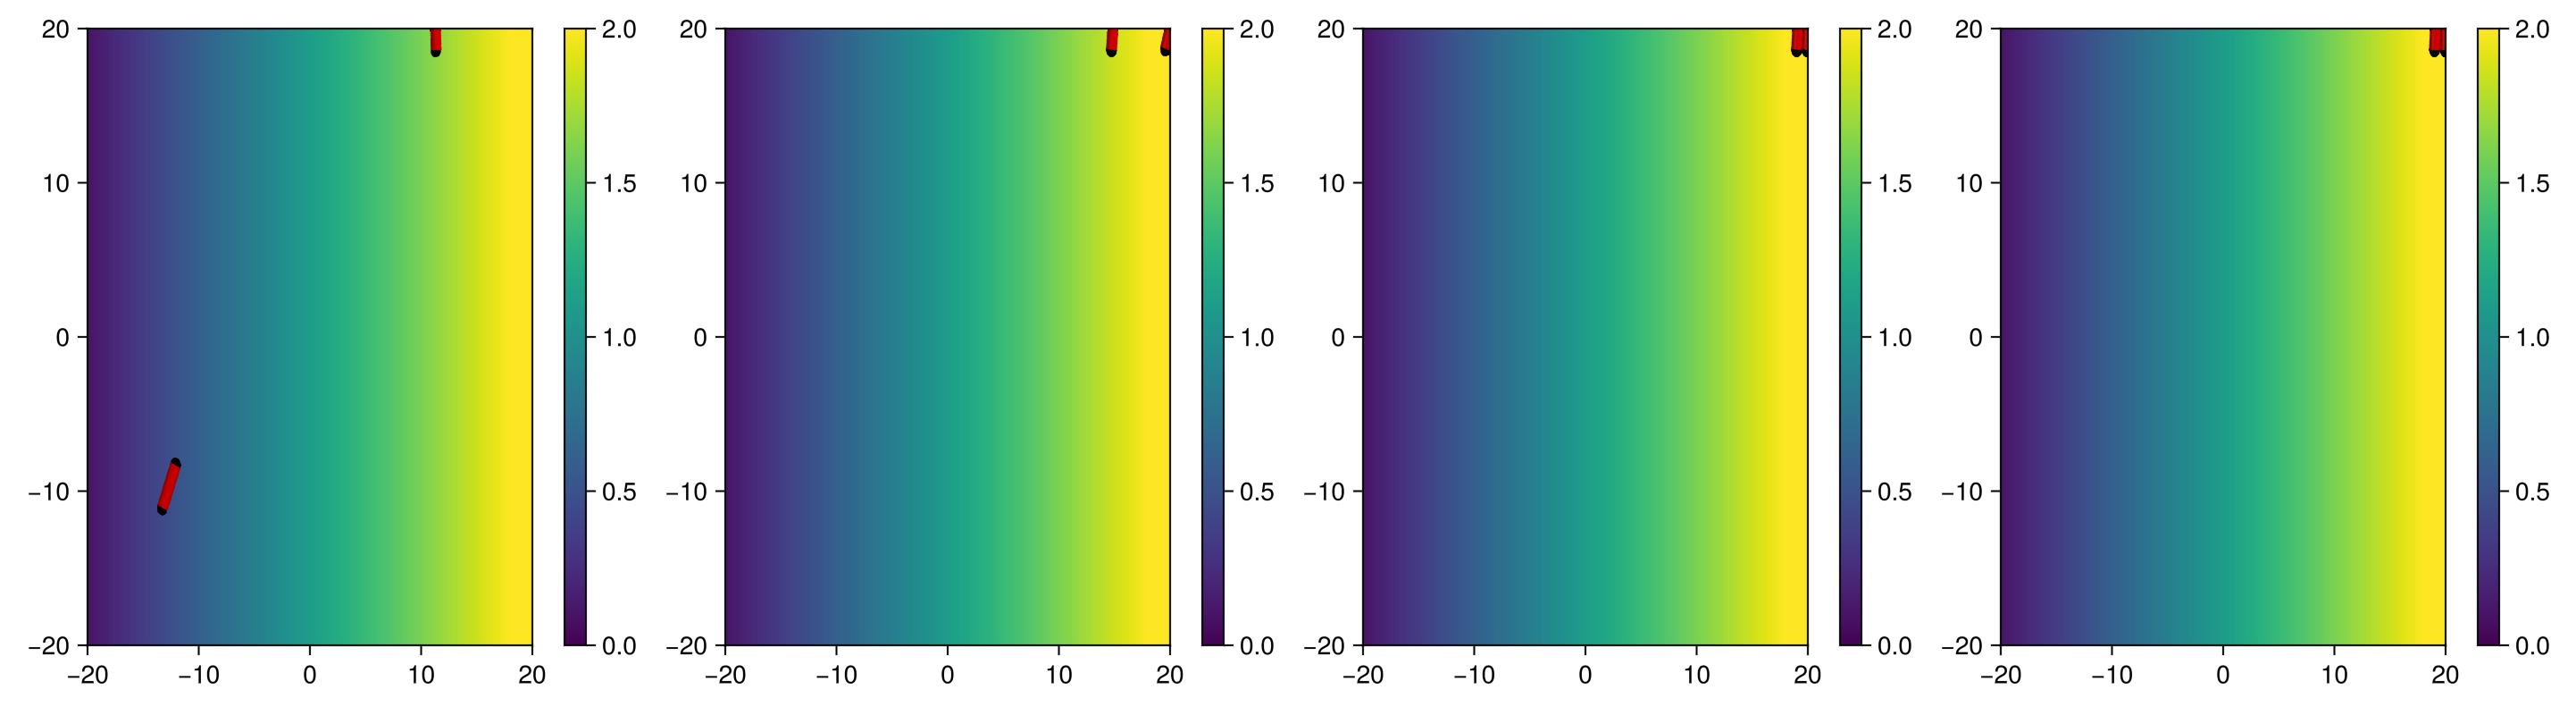

GLMakie.Screen(...)

In [24]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)


        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)